In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

# openPMD beamphysics examples

In [2]:
from pmd_beamphysics import ParticleGroup,  particle_paths
from pmd_beamphysics.readers import all_components, component_str

from h5py import File
import numpy as np
import os

In [3]:
# Open a file, fine the particle paths from the root attributes
# Pick one:
#H5FILE = 'data/bmad_particles.h5'
H5FILE = 'data/distgen_particles.h5'
#H5FILE = 'data/astra_particles.h5'
h5 = File(H5FILE, 'r')


ppaths = particle_paths(h5)
ppaths

'//'

In [4]:
# Point to particles
ph5 = h5[ppaths[0]]
list(ph5)

['momentum', 'particleStatus', 'position', 'time', 'weight']

In [5]:
# Search for all valid components
all_components(ph5)

['momentum/x',
 'momentum/y',
 'momentum/z',
 'particleStatus',
 'position/x',
 'position/y',
 'position/z',
 'time',
 'weight']

In [6]:
# Get some info
for component in all_components(ph5):
    info = component_str(ph5, component)
    print(info)

momentum/x [10000 items] is a momentum with units: kg*m/s
momentum/y [10000 items] is a momentum with units: kg*m/s
momentum/z [10000 items] is a momentum with units: kg*m/s
particleStatus [constant 1 with shape [10000]]
position/x [10000 items] is a length with units: m
position/y [10000 items] is a length with units: m
position/z [constant 0.0 with shape [10000]] is a length with units: m
time [10000 items] is a time with units: s
weight [constant 1e-15 with shape [10000]] is a charge with units: C


# ParticleGroup class

In [7]:
# Parse all these into a class
P = ParticleGroup(ph5)

In [8]:
?P

Type:        ParticleGroup
String form: ParticleGroup with 10000 particles with total charge 1.0000000000000003e-11 C
File:        ~/Code/GitHub/openPMD-beamphysics/pmd_beamphysics/particles.py
Docstring:  
Particle Group class

Initialized on on openPMD beamphysics particle group.

The fundamental bunch data is stored in __dict__ with keys
    str: species
    int: n_particle
    np.array: x, px, y, py, z, pz, t, status, weight
where:
    x, y, z are positions in units of [m]
    px, py, pz are momenta in units of [eV/c]
    t is time in [s]
    weight is the macro-charge weight in [C], used for all statistical calulations.
    
Derived data can be computed as attributes:
    .gamma, .beta, .beta_x, .beta_y, .beta_z: relativistic factors [1].
    .energy : total energy [eV]
    .kinetic_energy: total energy - mc^2 in [eV]. 
    .p: total momentum in [eV/c]
    .mass: rest mass in [eV]
    .xp, .yp: Slopes x' = dx/dz = dpx/dpz and y' = dy/dz = fpy/dpz [1].
    
Statistics of any of the

In [9]:
# x positions, in meters
P.x

array([-0.00118486, -0.00051813, -0.0017735 , ..., -0.00052658,
        0.00252813,  0.00113815])

In [10]:
# relativistic gamma, calculated on the fly
P.gamma

array([1.00000038, 1.00000074, 1.00000012, ..., 1.00000018, 1.00000039,
       1.00000044])

In [11]:
# Statistics on any of these. Note that these properly use the .weight array. 
P.avg('gamma'), P.std('p')

(1.0000004405134006, 187.3758567627587)

In [12]:
# Covariance matrix of any list of keys
P.cov('x', 'px', 'y', 'kinetic_energy')

array([[ 4.03109710e-06, -8.41425581e-03, -3.32976104e-08,
         1.42671675e-04],
       [-8.41425581e-03,  7.57940690e+04, -4.72281336e-03,
        -9.10354343e-01],
       [-3.32976104e-08, -4.72281336e-03,  3.90969742e-06,
        -6.21801644e-06],
       [ 1.42671675e-04, -9.10354343e-01, -6.21801644e-06,
         3.37638958e-02]])

In [13]:
# These can all be accessed with brackets. sigma_ and mean_ are also allowed
P['sigma_x'], P['sigma_energy'], P['min_y'], P['norm_emit_x']

(0.0020076588340617774,
 0.183740358638462,
 -0.00832584342723264,
 1.0815806511165722e-06)

In [14]:
# Covariance has a special syntax, items separated by __
P['cov_x__kinetic_energy']

0.00014267167501078306

In [15]:
# Units can be retrieved from any computable quantitiy.
# These are returned as a pmd_unit type.
P.units('x'), P.units('energy'), P.units('norm_emit_x'), P.units('cov_x__kinetic_energy')

(pmd_unit('m', 1, (1, 0, 0, 0, 0, 0, 0)),
 pmd_unit('eV', 1.602176634e-19, (2, 1, -2, 0, 0, 0, 0)),
 pmd_unit('m', 1, (1, 0, 0, 0, 0, 0, 0)),
 pmd_unit('m*eV', 1.602176634e-19, (3, 1, -2, 0, 0, 0, 0)))

In [16]:
P.units('mean_energy')

pmd_unit('eV', 1.602176634e-19, (2, 1, -2, 0, 0, 0, 0))

In [17]:
# 
str(P.units('cov_x__kinetic_energy'))

'm*eV'

In [18]:
# These particles are from Bmad, at the same z and different times
P.std('z'), P.std('t')

(0.0, 1.1604707204886252e-12)

In [19]:
# Get the central time
t0 = P.avg('t')
t0

1.8196640012738955e-14

In [20]:
# Drift all particles to this time
P.drift_to_t(t0)

In [21]:
# Now these are at different z, and the same t
P.std('z'), P.avg('t'), set(P.t)

(1.888210820118101e-07, 1.819664001273895e-14, {1.8196640012738955e-14})

# Writing

In [22]:
newh5file = 'particles.h5'

with File(newh5file, 'w') as h5:
    P.write(h5)
    
with File(newh5file, 'r') as h5:
    P2 = ParticleGroup(h5)    

In [23]:
# Check if all are the same
for key in ['x', 'px', 'y', 'py', 'z', 'pz', 't', 'status', 'weight']:
    same = np.all(P[key] == P2[key])
    print(key, same)

x True
px True
y True
py True
z True
pz True
t True
status True
weight True


In [24]:
# Write Astra-style particles
P.write_astra('astra.dat')

In [25]:
!head astra.dat

 -1.289719536974e-05   1.712460463101e-05  -1.014702487802e-09  -9.245284702413e-01  -3.316650265292e+00   2.210558337183e+02   1.819664001274e-05   0.000000000000e+00    1   -1
  1.003829639341e-03   0.000000000000e+00   1.014702487802e-09   0.000000000000e+00   0.000000000000e+00   0.000000000000e+00   3.155443620884e-30   0.000000000000e+00    1   -3
  0.000000000000e+00   9.885994047256e-04   1.014702487802e-09   0.000000000000e+00   0.000000000000e+00   0.000000000000e+00  -3.155443620884e-30   0.000000000000e+00    1   -3
  2.007659278682e-03   0.000000000000e+00   1.014702487802e-09   0.000000000000e+00   0.000000000000e+00   0.000000000000e+00   6.310887241768e-30   0.000000000000e+00    1   -3
  0.000000000000e+00   1.977198809451e-03   1.014702487802e-09   0.000000000000e+00   0.000000000000e+00   0.000000000000e+00  -6.310887241768e-30   0.000000000000e+00    1   -3
  3.011488918022e-03   0.000000000000e+00   1.014702487802e-09   0.000000000000e+00   0.000000000000e+00   0.0

In [26]:
# Optionally, a string can be given
P.write('particles.h5')

# Plot

Direct plotting. See plot_examples.ipynb for better plotting. 

In [27]:
import matplotlib.pyplot as plt
import matplotlib
cmap = plt.get_cmap('viridis')
cmap.set_under('white')
matplotlib.rcParams['figure.figsize'] = (13,8)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline


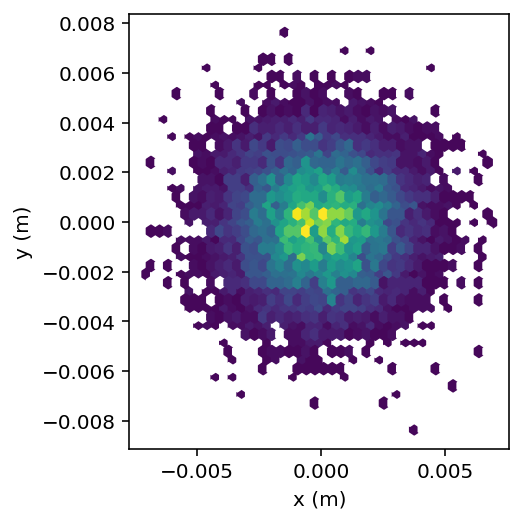

In [28]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
xkey = 'x'
ykey = 'y'
datx = P[xkey]
daty = P[ykey]
ax.set_xlabel(f'{xkey} ({P.units(xkey)})')
ax.set_ylabel(f'{ykey} ({P.units(ykey)})')
ax.hexbin(datx, daty, gridsize=40, cmap=cmap, vmin=1e-15)

In [29]:
# Cleanup
os.remove('astra.dat')
os.remove(newh5file)